In [16]:
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import csv
#Implementing the Skip-Gram Model
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = 200
%matplotlib inline
from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")
from sklearn.manifold import TSNE

In [2]:
#Preprocessing Part O
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
remove_terms = punctuation + '0123456789'

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    #Filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    #Filtering Stemmings
    filtered_tokens = [englishStemmer.stem(token) for token in filtered_tokens]
    #Filtering remove-terms
    filtered_tokens = [token for token in filtered_tokens if token not in remove_terms and len(token)>2]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [3]:
from read_data import *

In [4]:
#Extracting Data
filename = 'cve_dataset/cve_dataset.tsv'
cve_data = []
with open(filename, 'r') as tsv_file:
    tsv_reader = csv.reader(tsv_file, delimiter='\t')
    for line in tsv_reader:
        cve_data.append((line[1], line[2]))

issues_data = []
ground_truth = get_issues_ground_truth()
dataset = Dynamic_Dataset(ground_truth)
for d in dataset:
    issues_data.append(d)

wikipedia_data = []
for i in range(10000):
    with open('wiki_dataset/wikis/wiki_{}.txt'.format(i), 'r') as wiki_file:
        wikipedia_data.append(('(0,1)', wiki_file.read()))
        
data = cve_data + issues_data + wikipedia_data


In [5]:
def split_camel_case_token(token):
    return re.sub('([a-z])([A-Z])', r'\1 \2', token).split()

def clean_punctuation(token):
    remove_terms = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~0123456789'
    cleaned = token
    for p in remove_terms:
        cleaned = cleaned.replace(p, ' ')
    return cleaned.split()

def clean(token):
    to_return = clean_punctuation(token)
    new_tokens = []
    for t in to_return:
        new_tokens += split_camel_case_token(t)
    to_return = new_tokens
    return to_return

clean('get_creden-tialsExpir/ation()')

['get', 'creden', 'tials', 'Expir', 'ation']

In [7]:
#Normalization
#Create a Method
corpora = [sentence[1] for sentence in data]
norm_corpora = [sentence.split(' ') for sentence in corpora]

new_norm_corpora = []
for sentence in norm_corpora:
    new_sentence = []
    for word in sentence:
        new_token = clean(word)
        new_sentence += new_token
    new_norm_corpora.append(new_sentence)
norm_corpora = new_norm_corpora

norm_corpora = [[word.lower() for word in sent if word not in remove_terms] 
                for sent in norm_corpora]
norm_corpora = [' '.join(tok_sent) for tok_sent in norm_corpora]
norm_corpora = filter(None, normalize_corpus(norm_corpora))
norm_corpora = [tok_sent for tok_sent in norm_corpora if len(tok_sent.split()) > 2] #Len of the sentence

n_filter = 5
freqs = dict()
for sentence in norm_corpora:
    for word in sentence.split():
        freqs[word] = freqs.get(word, 0) + 1

norm_corpora = [' '.join([word for word in sentence.split() if freqs[word] >= n_filter]) for sentence in norm_corpora]


In [8]:
#1-Building the corpus vocabulary
tokenizer_corpora = text.Tokenizer()
tokenizer_corpora.fit_on_texts(norm_corpora)

In [9]:
word2id = tokenizer_corpora.word_index
id2word = {v:k for k, v in word2id.items()}

In [10]:
def get_weights(embeddings_filename):
    embeddings_df = pd.read_csv(embeddings_filename)
    weights = []
    for col in list(embeddings_df)[1:]:
        weights.append(list(embeddings_df[col]))
    return weights

In [19]:
weights = get_weights('word_embeddings-embed_size_100-epochs_100.csv')

In [20]:
#Verifying Closeness
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:4]+1] 
                   for search_term in ['vulner', 'attack', 'window', 'via', 'remot', 'code', 'user','exploit']}

(17227, 17227)


In [21]:
words = sum([[k] + v for k, v in similar_words.items()], [])
words_ids = [word2id[w] for w in words]
word_vectors = np.array([weights[idx] for idx in words_ids])

In [22]:
#T-SNE dimensionality Reduction
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(word_vectors)
labels = words

Total words: 32 	Word Embedding shapes: (32, 100)


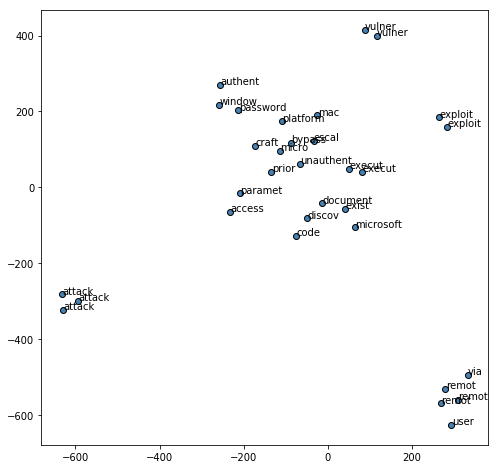

In [23]:
plt.figure(figsize=(8, 8))
plt.scatter(T[:, 0], T[:, 1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
print('Total words:', len(words), '\tWord Embedding shapes:', word_vectors.shape)